## EMG Preprocessing Pipeline (for activation timing analysis)

1. Band-pass filtering (Butterworth, 4th order, 20–100 Hz for fs=1000 Hz)

- Removes low-frequency motion artifacts (movement of electrodes, baseline drift)
- Removes high-frequency noise above the usable range (since Nyquist = 125 Hz at fs=250 Hz)
- Keeps the frequency band where most EMG power resides.

2. Notch filtering (Butterworth, 4th order, 60Hz for fs=1000Hz)

- remove powerline noise

3. Full-wave rectification (absolute value)
- Converts the oscillating EMG signal into positive-only values.
- Emphasizes signal magnitude, making it easier to analyze muscle activity.

4. Low-pass filtering (Butterworth, 4th order, cutoff ≈ 10 Hz)
- Smooths the rectified EMG to create the signal envelope.
- The envelope reflects overall muscle activation patterns over time.
- This step is especially useful for detecting muscle onset and offset timing.

### Summary

- Band-pass (20–450 Hz) → isolates the meaningful EMG band
- Notch filter (60Hz) → remove power-line noise
- Rectification → transforms the signal into an amplitude-based representation
- Low-pass (~10 Hz) → extracts the envelope, highlighting activation timing

In [1]:
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path='../data/1000hz.csv'
data = pd.read_csv(path)

emg_raw = data.iloc[:,0:8].copy().to_numpy()

In [3]:
emg_raw = data.iloc[:,0:8].copy().to_numpy()

In [4]:
emg_raw.shape

(85472, 8)

In [5]:
from scipy.signal import butter, filtfilt, iirnotch
import numpy as np

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a 

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    padlen = min(3 * max(len(a), len(b)), data.shape[0]-1)
    return filtfilt(b, a, data, axis=0, padlen=padlen)

def lowpass_filter(data, cutoff, fs, order=4):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low')
    padlen = min(3 * max(len(a), len(b)), data.shape[0]-1)
    return filtfilt(b, a, data, axis=0, padlen=padlen)

def notch_filter(data, notch_freq, fs, quality_factor=30):
    nyquist = 0.5 * fs
    w0 = notch_freq / nyquist  # Normalized Frequency
    b, a = iirnotch(w0, quality_factor)
    padlen = min(3 * max(len(a), len(b)), data.shape[0]-1)
    return filtfilt(b, a, data, axis=0, padlen=padlen)

# Example parameters
fs = 1000  # Hz
lowcut, highcut = 20, 450
notch_freq = 60  # Hz
quality_factor = 30  # Typical value; higher = narrower notch

# 3. Preprocessing pipeline.

# (1) Band-pass filtering (20–450 Hz)
emg_filtered = bandpass_filter(emg_raw, lowcut, highcut, fs)

# (2) Notch filtering (remove 60 Hz)
emg_filtered = notch_filter(emg_filtered, notch_freq, fs, quality_factor)

# (3) Full-wave rectification
emg_rectified = np.abs(emg_filtered)

# (4) Envelope extraction (low-pass ~10 Hz)
emg_envelope = lowpass_filter(emg_rectified, cutoff=10, fs=fs)


In [6]:
emg_envelope.shape

(85472, 8)

In [7]:
filtered = pd.DataFrame(emg_envelope, columns=['ch1','ch2','ch3','ch4','ch5','ch6','ch7','ch8'])

In [8]:
filtered.head()

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8
0,1955.231180,3053.101247,1296.714180,3061.322263,659.198177,2127.744824,10462.746230,3693.969807
1,2090.362144,3657.713597,1590.503051,3790.837769,914.762515,2312.688985,11040.030058,4304.543929
2,2231.710835,4251.609499,1885.255131,4523.794900,1170.845541,2501.736774,11608.317948,4911.114357
3,2379.166824,4833.635749,2180.514618,5259.139118,1427.095129,2694.720505,12166.173942,5512.479577
4,2532.599537,5402.671469,2475.817849,5995.799026,1683.156894,2891.463975,12712.183265,6107.444826


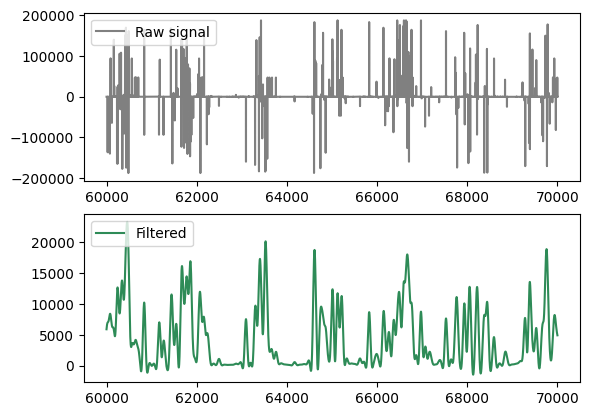

In [9]:
start=60000
end=70000
fig, axes = plt.subplots(2, 1)
# Plot: Raw signal
axes[0].plot(data.loc[start:end,'CH1'], color='grey', label='Raw signal')
axes[0].legend(loc='upper left')

# Plot: Filtered
axes[1].plot(filtered.loc[start:end, 'ch1'], color='seagreen', label='Filtered')
axes[1].legend(loc='upper left')

In [10]:
import matplotlib.pyplot as plt

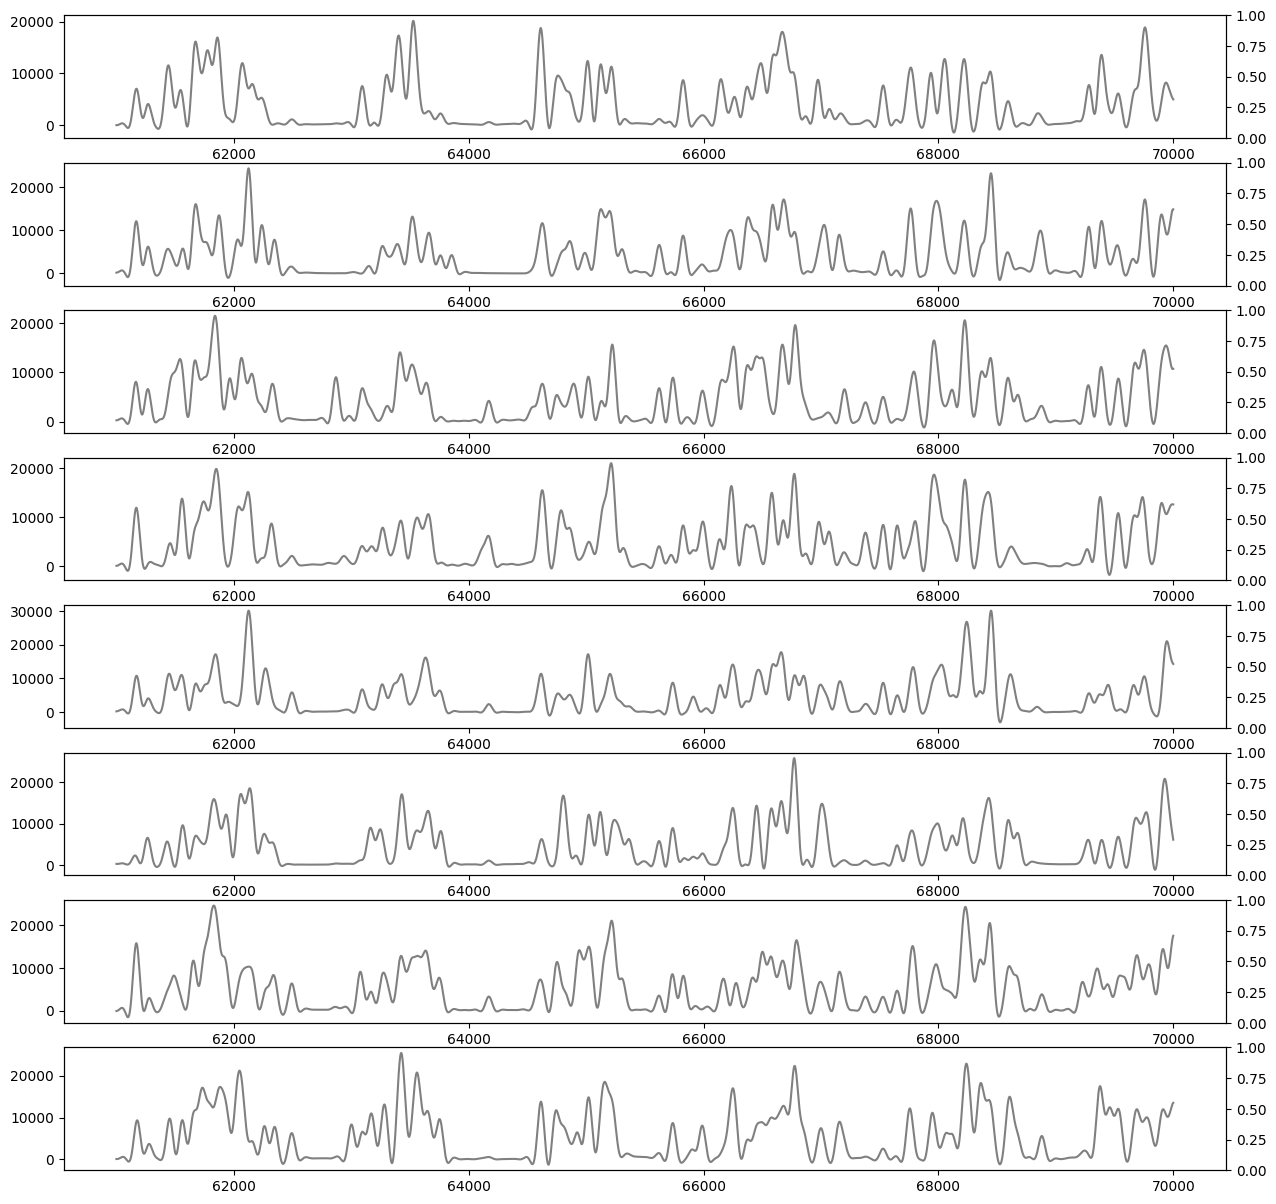

In [11]:
start = 61000
end = 70000

fig, axes = plt.subplots(8,1, figsize=(15,15))

axes[0].plot(filtered.ch1[start:end], color='grey')
axes_0 = axes[0].twinx()
#axes_0.plot(data.Label[start:end], color='red')

axes[1].plot(filtered.ch2[start:end], color='grey')
axes_1 = axes[1].twinx()
#axes_1.plot(data.Label[start:end], color='red')

axes[2].plot(filtered.ch3[start:end], color='grey')
axes_2 = axes[2].twinx()
#axes_2.plot(data.Label[start:end], color='red')

axes[3].plot(filtered.ch4[start:end], color='grey')
axes_3 = axes[3].twinx()
#axes_3.plot(data.Label[start:end], color='red')

axes[4].plot(filtered.ch5[start:end], color='grey')
axes_4 = axes[4].twinx()
#axes_4.plot(data.Label[start:end], color='red')

axes[5].plot(filtered.ch6[start:end], color='grey')
axes_5 = axes[5].twinx()
#axes_5.plot(data.Label[start:end], color='red')

axes[6].plot(filtered.ch7[start:end], color='grey')
axes_6 = axes[6].twinx()
#axes_6.plot(data.Label[start:end], color='red')

axes[7].plot(filtered.ch8[start:end], color='grey')
axes_7 = axes[7].twinx()
#axes_7.plot(data.Label[start:end], color='red')

